In [1]:
import numpy as np
import pickle
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Layer:
    def __init__(self, input_size, output_size, activation_name='relu'):
        self.input_size = input_size
        self.output_size = output_size
        self.activation_name = activation_name
        
        if activation_name=='relu' or activation_name=="leaky_relu":
            # He initialisation
            self.weights = np.random.randn(output_size, input_size) * np.sqrt(2.0 / (input_size))
        else:
            # Xavier/Glorot initialization
            self.weights = np.random.randn(output_size, input_size) * np.sqrt(2.0 / (input_size + output_size))
        self.biases = np.zeros((output_size, 1))
    
    def get_params(self):
        return self.weights.size + self.biases.size

In [3]:
class NN:
    def __init__(self, learning_rate=0.01, epochs=200):
        self.layers = []
        self.lr = learning_rate
        self.epochs = epochs
        
    def add(self, layer):
        self.layers.append(layer)
    
    def _get_activation(self, name):
        def linear(x, derivative=False):
            return 1 if derivative else x
               
        def relu(x, derivative=False):
            return np.where(x > 0, 1, 0) if derivative else np.maximum(0, x)
        
        def tanh(x, derivative=False):
            return np.tanh(x) if not derivative else 1 - np.tanh(x)**2
        
        def leaky_relu(x, alpha=0.01, derivative=False):
            return np.where(x >= 0, x, alpha * x) if not derivative else np.where(x >= 0, 1, alpha)
        
        def sigmoid(x, derivative=False):
            clipped_x = np.clip(x, -500, 500)
            if derivative:
                sigmoid_x = 1 / (1 + np.exp(-clipped_x))
                return sigmoid_x * (1 - sigmoid_x)
            return 1 / (1 + np.exp(-clipped_x))
        
        def softmax(x, derivative=False):
            if derivative:
                return x * (1 - x)
            exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))
            return exp_x / np.sum(exp_x, axis=0, keepdims=True)

        match name.lower():
            case 'linear': return linear
            case 'relu': return relu
            case 'tanh': return tanh
            case 'leaky_relu': return leaky_relu
            case 'sigmoid': return sigmoid
            case 'softmax': return softmax
            case _: return linear
            
    def summary(self):
        print("Model Summary:")
        print("---------------")
        total_params = 0
        print(f"{'Layer (type)':<20}{'Output Shape':<20}{'Param #':<10}")
        print("="*50)
        
        for i, layer in enumerate(self.layers):
            print(f"{f'Layer {i}':<20}{f'({layer.output_size},)':<20}{layer.get_params():<10}")
            total_params += layer.get_params()
        
        print("="*50)
        print(f"Total params: {total_params}")
    
    def forward_pass(self, X):
        activations = [X]
        z_values = []
        
        for i, layer in enumerate(self.layers):
            z = np.dot(layer.weights, activations[-1]) + layer.biases
            z_values.append(z)
            a = self._get_activation(layer.activation_name)(z)        
            activations.append(a)
        
        return activations, z_values
    
    def backward_pass(self, X, y, activations, z_values):
        m = X.shape[1]
        dW = []
        db = []
        
        # Prepare labels based on last layer activation
        last_activation = self.layers[-1].activation_name
        if last_activation == 'softmax':
            y_encoded = np.zeros_like(activations[-1])
            for i in range(m):
                y_encoded[y[i], i] = 1
            dZ = activations[-1] - y_encoded
        else:  # sigmoid (binary classification)
            dZ = activations[-1] - y.reshape(1, -1)
        
        for i in range(len(self.layers) - 1, -1, -1):
            # Compute gradients
            dW.insert(0, np.dot(dZ, activations[i].T) / m)
            db.insert(0, np.sum(dZ, axis=1, keepdims=True) / m)
            
            # Compute gradient for next layer if not input layer
            if i > 0:
                activation_derivative = self._get_activation(self.layers[i-1].activation_name)
                dZ = np.dot(self.layers[i].weights.T, dZ) * activation_derivative(z_values[i-1], derivative=True)
        
        return dW, db
    
    def train(self, X, y, verbose=False, freq=100):
        freq = max(freq, 1)
        losses = []
        last_activation = self.layers[-1].activation_name
        start = time.time()
        
        for epoch in range(self.epochs):
            # Forward pass
            activations, z_values = self.forward_pass(X)
            
            # Compute loss based on last layer activation
            if last_activation == 'softmax':
                y_encoded = np.zeros_like(activations[-1])
                for i in range(X.shape[1]):
                    y_encoded[y[i], i] = 1
                loss = -np.sum(y_encoded * np.log(activations[-1] + 1e-15)) / X.shape[1]
            else:  # sigmoid (binary cross-entropy)
                loss = -np.mean(y * np.log(activations[-1] + 1e-15) + 
                                (1 - y) * np.log(1 - activations[-1] + 1e-15))
            
            losses.append(loss)
            
            # Backward pass
            dW, db = self.backward_pass(X, y, activations, z_values)
            
            # Update parameters
            for i in range(len(self.layers)):
                self.layers[i].weights -= self.lr * dW[i]
                self.layers[i].biases -= self.lr * db[i]
            
            # Print loss periodically
            if verbose or epoch % freq == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}, Time: {time.time()-start:.2f}")
                start = time.time()
        
        return losses
    
    def predict(self, X):
        activations, _ = self.forward_pass(X)
        last_activation = self.layers[-1].activation_name
        
        if last_activation == 'softmax':
            return np.argmax(activations[-1], axis=0)
        else:  # sigmoid
            return (activations[-1] > 0.5).astype(int)
        
    def save_model(self, filepath):
        model_data = {
            'layers': [(layer.input_size, layer.output_size, layer.activation_name) for layer in self.layers],
            'weights': [layer.weights for layer in self.layers],
            'biases': [layer.biases for layer in self.layers],
            'learning_rate': self.lr,
            'epochs': self.epochs
        }
        
        with open(filepath, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"Model saved to {filepath}")
    
    def load_model(self, filepath):
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"Model file {filepath} not found")
        
        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)
        
        # Reset layers and reconstruct network
        self.layers = []
        for input_size, output_size, activation_name in model_data['layers']:
            layer = Layer(input_size, output_size, activation_name)
            self.layers.append(layer)
        
        # Restore weights and biases
        for i, (layer, weights, biases) in enumerate(zip(self.layers, model_data['weights'], model_data['biases'])):
            layer.weights = weights
            layer.biases = biases
        
        # Restore other parameters
        self.lr = model_data['learning_rate']
        self.epochs = model_data['epochs']
        
        print(f"Model loaded from {filepath}")
        return self

In [4]:
def mnist_to_csv(imgf, labelf, outf, n=1000):
    """
    Converts MNIST image and label files to a CSV format.
    
    Args:
        imgf (str): Path to the image file.
        labelf (str): Path to the label file.
        outf (str): Path to the output CSV file.
        n (int): Number of images to process (default: 1000).
    """
    with open(imgf, "rb") as f, open(labelf, "rb") as l, open(outf, "w") as o:
        # Skip header information
        f.read(16)
        l.read(8)
        
        for _ in range(n):
            label = l.read(1)[0]  # label
            pixels = f.read(28 * 28)  # 28x28 pixels = 784 inputs
            o.write(f"{label}," + ",".join(map(str, pixels)) + "\n")


In [ ]:
mnist_to_csv("./mnist/train-images.idx3-ubyte", "./mnist/train-labels.idx1-ubyte", "./dataset/train.csv",  60000)
mnist_to_csv("./mnist/t10k-images.idx3-ubyte", "./mnist/t10k-labels.idx1-ubyte", "./dataset/test.csv", 10000)

# Load the CSV data using numpy
train = np.loadtxt('./dataset/train.csv', delimiter=',')
test = np.loadtxt('./dataset/test.csv', delimiter=',')

In [ ]:
# Data Preprocessing
X_train = train.iloc[:, 1:].values.T / 255.0
Y_train = train.iloc[:, 0].values

X_test = test.iloc[:, 1:].values.T /255.0 
Y_test = test.iloc[:, 0].values

In [7]:
# Create neural network
model = NN(learning_rate=0.01, epochs=1000)

# Add layers
model.add(Layer(784, 128, 'relu'))
model.add(Layer(128, 64, 'relu'))
model.add(Layer(64, 10, 'softmax'))

# Display model summary
model.summary()

Model Summary:
---------------
Layer (type)        Output Shape        Param #   
Layer 0             (128,)              100480    
Layer 1             (64,)               8256      
Layer 2             (10,)               650       
Total params: 109386


In [8]:
# Train the model
losses = model.train(X_train, Y_train)

Epoch 0, Loss: 2.3433, Time: 0.78
Epoch 100, Loss: 1.6053, Time: 70.66
Epoch 200, Loss: 1.1167, Time: 74.89
Epoch 300, Loss: 0.8385, Time: 68.29
Epoch 400, Loss: 0.6846, Time: 81.32
Epoch 500, Loss: 0.5913, Time: 75.55
Epoch 600, Loss: 0.5295, Time: 70.76
Epoch 700, Loss: 0.4856, Time: 64.56
Epoch 800, Loss: 0.4528, Time: 87.23
Epoch 900, Loss: 0.4274, Time: 84.30


Text(0, 0.5, 'Loss')

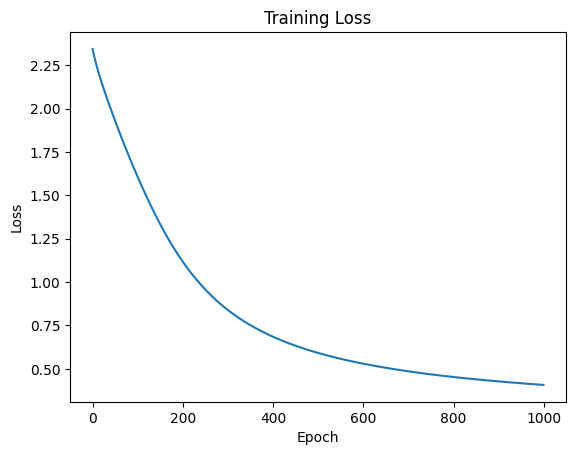

In [9]:
# Plot the training loss
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 1.0, 'Test Accuracy: 89.47%')

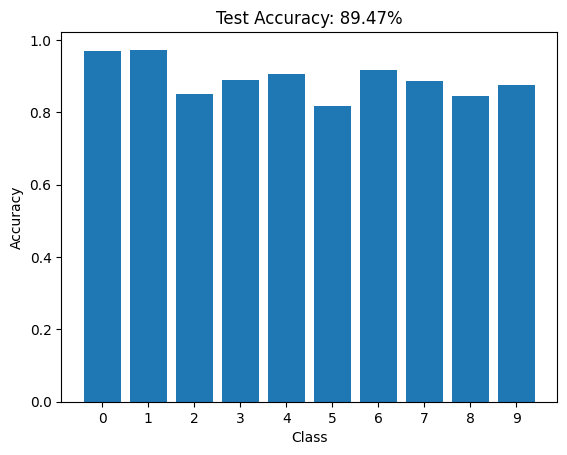

In [10]:
# Model Accuracy
predictions = model.predict(X_test)
overall_accuracy = np.mean(predictions == Y_test)

unique_classes = np.unique(Y_test)
class_accuracies = []

for cls in unique_classes:
    cls_predictions = predictions[Y_test == cls]
    class_accuracies.append(np.mean(cls_predictions == cls))

plt.bar(unique_classes, class_accuracies)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(unique_classes)
plt.title(f"Test Accuracy: {overall_accuracy * 100:.2f}%")

In [67]:
model.save_model('./results/models/doubleLayer.pkl')

Model saved to ./results/models/doubleLayer.pkl
